### In|OUT vs BAD

/tmp/ipykernel_5962/2432368693.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['label_inout_bad'] = clean_df[INTEREST_LABEL].apply(lambda x: 'IN_OUT' if x in ['IN', 'OUT'] else 'BAD')
/tmp/ipykernel_5962/2432368693.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label_inout_bad_encoded'] = label_encoder.fit_transform(train_df['label_inout_bad'])


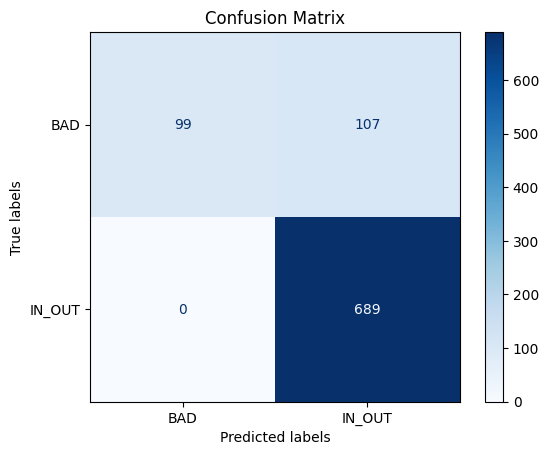

In [153]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from utils import aggregate_and_compare_predictions, plot_confusion_matrix, plot_false_positives, calculate_confidence_distribution

def train_and_predict_direction_model(features_df, features_list, save_file=None):
    INTEREST_LABEL = 'label_direction'

    # Data cleaning and preparation
    clean_df = features_df.dropna(subset=[INTEREST_LABEL])
    clean_df['label_inout_bad'] = clean_df[INTEREST_LABEL].apply(lambda x: 'IN_OUT' if x in ['IN', 'OUT'] else 'BAD')
    
    
    
    ###### 50 y 50 ######
    # Split the cleaned DataFrame into two based on label_inout_bad
    df_in_out = clean_df[clean_df['label_inout_bad'] == 'IN_OUT']
    df_bad = clean_df[clean_df['label_inout_bad'] == 'BAD']

    # Randomly sample 50 entries for each case
    np.random.seed(42)

    df_in_out_ids = df_in_out['id'].unique()
    df_in_out_ids = np.random.choice(df_in_out_ids, 50, replace=False)

    df_bad_ids = df_bad['id'].unique()
    df_bad_ids = np.random.choice(df_bad_ids, 50, replace=False)

    df_in_out_sample = df_in_out[df_in_out['id'].isin(df_in_out_ids)]
    df_bad_sample = df_bad[df_bad['id'].isin(df_bad_ids)]

    # Combine the samples to form the training dataset
    train_df = pd.concat([df_in_out_sample, df_bad_sample])

    # Make sure to select the prediction set from the cleaned data excluding the training set
    predict_df = clean_df.drop(train_df.index)
    ###### 50 y 50 ######
    
    

    train_df = clean_df[(clean_df['id'] < 1300)]
    predict_df = clean_df[(clean_df['id'] >= 1300)]

    label_encoder = LabelEncoder()
    train_df['label_inout_bad_encoded'] = label_encoder.fit_transform(train_df['label_inout_bad'])

    target = 'label_inout_bad_encoded'

    # Split the data into training and testing sets
    X_train, X_val, y_train, y_val = train_test_split(train_df[features_list], train_df[target], test_size=0.2, random_state=42)

    # Initialize and train the Gradient Boosting Classifier
    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Validation
    # val_predictions = model.predict(X_val)
    # val_accuracy = accuracy_score(y_val, val_predictions)
    # print(f"Validation Accuracy: {val_accuracy}")

    # Prediction
    predict_df = predict_df.dropna(subset=features_list)
    predict_features = predict_df[features_list]
    predicted_labels = model.predict(predict_features)
    predicted_confidences = model.predict_proba(predict_features).max(axis=1)

    # Adding predictions back to the dataframe
    predict_df['model_label_good_direction'] = predicted_labels
    predict_df['model_label_good_direction_conf'] = predicted_confidences
    predict_df['model_label_good_direction'] = label_encoder.inverse_transform(predict_df['model_label_good_direction'].astype(int))

    # Combine the prediction and training dataframes
    final_df = pd.concat([train_df, predict_df], sort=False)

    # Optionally save the final DataFrame
    if save_file is not None:
        final_df.to_csv(save_file, index=False)
    # print("LabelEncoder classes:", label_encoder.classes_)
    # print("LabelEncoder inverse transform:", label_encoder.inverse_transform([1,0]))
    return final_df

# Example usage
BASE_FOLDER_NAME = 'results'
FILE_NAME = 'data_prep_conce_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, FILE_NAME)
features_df = pd.read_csv(CSV_FILE_PATH)
MODEL_RESULT = os.path.join(BASE_FOLDER_NAME, f'model_inout_vs_bad_{FILE_NAME}')
MODEL_RESULT = None

features_list = [
# 'x1',
# 'y1',
# 'x2',
# 'y2',
# 'centroid_x',
# 'centroid_y',
# 'distance_to_center',
# 'delta_x',
# 'delta_y',
'initial_x',
'initial_y',
'final_x',
'final_y',
	# 'total_distance',
	# 'direction_x',
	# 'direction_y',
# 'delta_x_mean',
# 'delta_x_max',
# 'delta_x_min',
# 'delta_x_std',
# 'delta_y_mean',
# 'delta_y_max',
# 'delta_y_min',
# 'delta_y_std',
# 'net_movement_x',
# 'net_movement_y',
'net_movement_x_mean',
'net_movement_y_mean',
# 'delta_mean_x',
# 'delta_mean_y',
'centroid_y_std',
# 'centroid_x_std',

'delta_x_final',
'delta_y_final',
]

final_df = train_and_predict_direction_model(features_df, features_list,MODEL_RESULT)
agg_df = aggregate_and_compare_predictions(final_df, 'model_label_good_direction', 'label_inout_bad')
plot_confusion_matrix(agg_df)

### 50 / 50 Ratio

/tmp/ipykernel_5962/1874571127.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['label_inout_bad'] = clean_df[INTEREST_LABEL].apply(lambda x: 'IN_OUT' if x in ['IN', 'OUT'] else 'BAD')


Validation Accuracy: 1.0
LabelEncoder classes: ['BAD' 'IN_OUT']
LabelEncoder inverse transform: ['IN_OUT' 'BAD']
Updated CSV saved successfully.


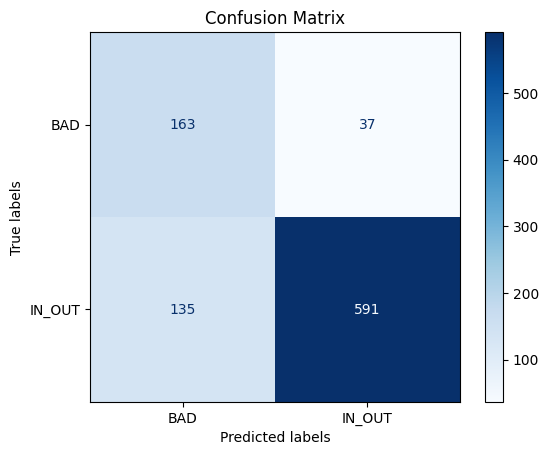

In [19]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from utils import aggregate_and_compare_predictions, plot_confusion_matrix, plot_false_positives, calculate_confidence_distribution

BASE_IMAGES_PATH = '/home/diego/Documents/yolov7-tracker/imgs_conce'
BASE_FOLDER_NAME = 'results'
FILE_NAME = 'data_prep_conce_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, FILE_NAME)
INTEREST_LABEL = 'label_direction'

MODEL_RESULT = os.path.join(BASE_FOLDER_NAME, f'model_inout_vs_bad_{FILE_NAME}')

# Load the DataFrame
df = pd.read_csv(CSV_FILE_PATH)

# Define your INTEREST_LABEL column name
INTEREST_LABEL = 'label_direction'  # Adjust based on your actual column name

# Clean the DataFrame
clean_df = df.dropna(subset=[INTEREST_LABEL])
clean_df['label_inout_bad'] = clean_df[INTEREST_LABEL].apply(lambda x: 'IN_OUT' if x in ['IN', 'OUT'] else 'BAD')

# Split the cleaned DataFrame into two based on label_inout_bad
df_in_out = clean_df[clean_df['label_inout_bad'] == 'IN_OUT']
df_bad = clean_df[clean_df['label_inout_bad'] == 'BAD']

# Randomly sample 50 entries for each case
np.random.seed(42)

df_in_out_ids = df_in_out['id'].unique()
df_in_out_ids = np.random.choice(df_in_out_ids, 50, replace=False)

df_bad_ids = df_bad['id'].unique()
df_bad_ids = np.random.choice(df_bad_ids, 50, replace=False)

df_in_out_sample = df_in_out[df_in_out['id'].isin(df_in_out_ids)]
df_bad_sample = df_bad[df_bad['id'].isin(df_bad_ids)]

# Combine the samples to form the training dataset
train_df = pd.concat([df_in_out_sample, df_bad_sample])

# Make sure to select the prediction set from the cleaned data excluding the training set
predict_df = clean_df.drop(train_df.index)

# Proceed with encoding and feature selection
label_encoder = LabelEncoder()
train_df['label_inout_bad_encoded'] = label_encoder.fit_transform(train_df['label_inout_bad'])

# Define not important features list, adjust as per your specific column names
features = [
    'x1', 'y1', 'x2', 'y2', 'centroid_x', 'centroid_y', 'distance_to_center',
    'delta_x', 'delta_y', 'delta_x_mean', 'delta_x_max', 'delta_x_min', 'delta_x_std',
    'delta_y_mean', 'delta_y_max', 'delta_y_min', 'delta_y_std',
    'net_movement_x', 'net_movement_y',
]

target = 'label_inout_bad_encoded'

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

##################################################################
# Predict on the test set
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")



predict_df = predict_df.dropna(subset=features)
# Predicting on the dataset without labels
predict_features = predict_df[features]
predicted_labels = model.predict(predict_features)
predicted_confidences = model.predict_proba(predict_features).max(axis=1)

# Adding predictions back to the dataframe
predict_df['model_label_good_direction'] = predicted_labels
predict_df['model_label_good_direction_conf'] = predicted_confidences
predict_df['model_label_good_direction'] = label_encoder.inverse_transform(predict_df['model_label_good_direction'].astype(int))

# Combine the prediction and training dataframes
final_df = pd.concat([train_df, predict_df], sort=False)

# Save the updated dataframe to a new CSV file
final_df.to_csv(MODEL_RESULT, index=False) 

print("LabelEncoder classes:", label_encoder.classes_)
print("LabelEncoder inverse transform:", label_encoder.inverse_transform([1,0]))
print("Updated CSV saved successfully.")

################################################ TESTING ################################################
agg_df = aggregate_and_compare_predictions(final_df, 'model_label_good_direction', 'label_inout_bad')
plot_confusion_matrix(agg_df)